ThinCurr Python Example: Compute eigenstates using HODLR {#doc_tCurr_hodlr_eig}
==========
In this example we demonstrate how to compute eigenvalues and eigenvectors for a large ThinCurr model using HODLR matrix compression.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) and [pyvista](https://pyvista.org/) python packages, which are installable using `pip` or other standard methods.

In [1]:
import struct
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pyvista
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load ThinCurr library

To load the ThinCurr python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` for binaries on macOS).

In [2]:
thincurr_python_path = os.getenv('OFT_ROOTPATH')
if thincurr_python_path is not None:
    sys.path.append(os.path.join(thincurr_python_path,'python'))
from OpenFUSIONToolkit.ThinCurr import ThinCurr
from OpenFUSIONToolkit.ThinCurr.meshing import write_ThinCurr_mesh, build_torus_bnorm_grid, build_periodic_mesh
from OpenFUSIONToolkit.util import build_XDMF

## Compute eigenvalues

### Setup ThinCurr model
We now create a \ref OpenFUSIONToolkit.ThinCurr.ThinCurr "ThinCurr" instance to use for equilibrium calculations. As this is a larger model, we use `nthreads=4` to increase the number of cores used for the calculation. Once created, we setup the model from an existing HDF5 and XML mesh definition using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_model "setup_model()". We also initialize I/O for this model using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.setup_io "setup_io()" to enable output of plotting files for 3D visualization in [VisIt](https://visit-dav.github.io/visit-website/index.html), [Paraview](https://www.paraview.org/), or using [pyvista](https://pyvista.org/) below.

In [3]:
tw_torus = ThinCurr(nthreads=4)
tw_torus.setup_model(mesh_file='thincurr_ex-ports.h5',xml_filename='oft_in.xml')
tw_torus.setup_io()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tCurr_SIMSOPT
Revision id:          3a704f3
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    4
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------


Creating thin-wall model
 Orientation depth =       26500
  Loading V(t) driver coils
  Loading I(t) driver coils

  # of points    =        22580
  # of edges     =        67150
  # of cells     =        44560
  # of holes     =           11
  # of pcoils    =            0
  # of closures  =            0
  # of Icoils    =            1

  Building holes

  Loading region resistivit

### Compute self-inductance and resistivity matrices
With the model setup, we can now compute the self-inductance matrix using HODLR. When HODLR is used the result is a pointer to the Fortran operator, which is stored at \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.Lmat_hodlr "tw_torus.Lmat_hodlr". As in any other case, by default, the resistivity matrix is not moved to python as it is sparse and converting to dense representation would require an increase in memory. These matrices correspond to the $\textrm{L}$ and $\textrm{R}$ matrices for the physical system

$\textrm{L} \frac{\partial I}{\partial t} + \textrm{R} I = V$

**Note:** Even though HODLR should significantly accelerate the construction of the self-inductance matrix (see \ref doc_thincurr_ex4 for more information) this process may still take some time to complete.

**Note:** The non-zero savings achieved by HODLR compression is reported after the operator is built. Where in this case only 6% of the original memory is needed resulting in a reduction from > 3 GB to ~ 230 MB!

In [4]:
tw_torus.compute_Lmat(use_hodlr=True)
tw_torus.compute_Rmat()

 Partitioning grid for block low rank compressed operators
   nBlocks =                  32
   Avg block size =          686
   # of SVD =                167
   # of ACA =                161
 Building block low rank inductance operator
   Building diagonal blocks
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
   Building off-diagonal blocks using ACA+
     10%
     20%
     30%
     40%
     50%
     60%
     70%
     80%
     90%
     Compression ratio:   6.1%  ( 2.94E+07/ 4.82E+08)
     Time =  1m 28s      
   Building hole and Vcoil columns
 Building resistivity matrix


### Compute eigenvalues/eigenvectors for the plate model
With $\textrm{L}$ and $\textrm{R}$ matrices we can now compute the eigenvalues and eigenvectors of the system $\textrm{L} I = \lambda \textrm{R} I$, where the eigenvalues $\lambda = \tau_{L/R}$ are the decay time-constants of the current distribution corresponding to each eigenvector.

In [5]:
eig_vals, eig_vecs = tw_torus.get_eigs(5,False)

 Starting eigenvalue solve
   Time =   0.24706700000000001     
 Eigenvalues
      3.8803529173958989E-002
      2.3122413703786586E-002
      2.3121318260644157E-002
      2.1444730547711947E-002
      2.0605569150165096E-002


### Save data for plotting
The resulting currents can be saved for plotting using \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.save_current "tw_torus.save_current()". Here we save each of the five eigenvectors for visualization. Once all fields have been saved for plotting \ref OpenFUSIONToolkit.ThinCurr.ThinCurr.build_XDMF "tw_torus.build_XDMF()" to generate the [XDMF descriptor files](https://www.xdmf.org/index.php/XDMF_Model_and_Format) for plotting with VisIt of Paraview.

In [6]:
tw_torus.save_current(eig_vecs[0,:],'J_01')
tw_torus.save_current(eig_vecs[1,:],'J_02')
tw_torus.save_current(eig_vecs[2,:],'J_03')
tw_torus.save_current(eig_vecs[3,:],'J_04')
tw_torus.build_XDMF()

Removing old Xdmf files
Creating output files


## Plot current fields using pyvista
For demonstration purposes we now plot the first eigenvector using [pyvista](https://pyvista.org/).

### Load data from plot files
To plot the fields we must load in the mesh from the plot files.

**Note:** In the future this will be handled by dedicated python functions, but we show it here at the moment for demonstration purposes.

In [7]:
with h5py.File('mesh.0001.h5','r') as h5_file:
    r = np.asarray(h5_file['R_surf'])
    lc = np.asarray(h5_file['LC_surf'])
with h5py.File('vector_dump.0001.h5','r') as h5_file:
    J_01 = np.asarray(h5_file['J_01_v0000'])

### Create pyvista mesh for plotting
Now we create a pyvista/VTK mesh from the loaded information and add the vector field to the mesh.

In [8]:
celltypes = np.array([pyvista.CellType.TRIANGLE for _ in range(lc.shape[0])], dtype=np.int8)
cells = np.insert(lc, [0,], 3, axis=1)
grid = pyvista.UnstructuredGrid(cells, celltypes, r)
grid["vectors"] = J_01
grid.set_active_vectors("vectors")

## Plot current vectors on surface
Finally we plot the current vectors on the plate showing the longest-lived eddy current structure, which corresponds to a large circulation on the plate.

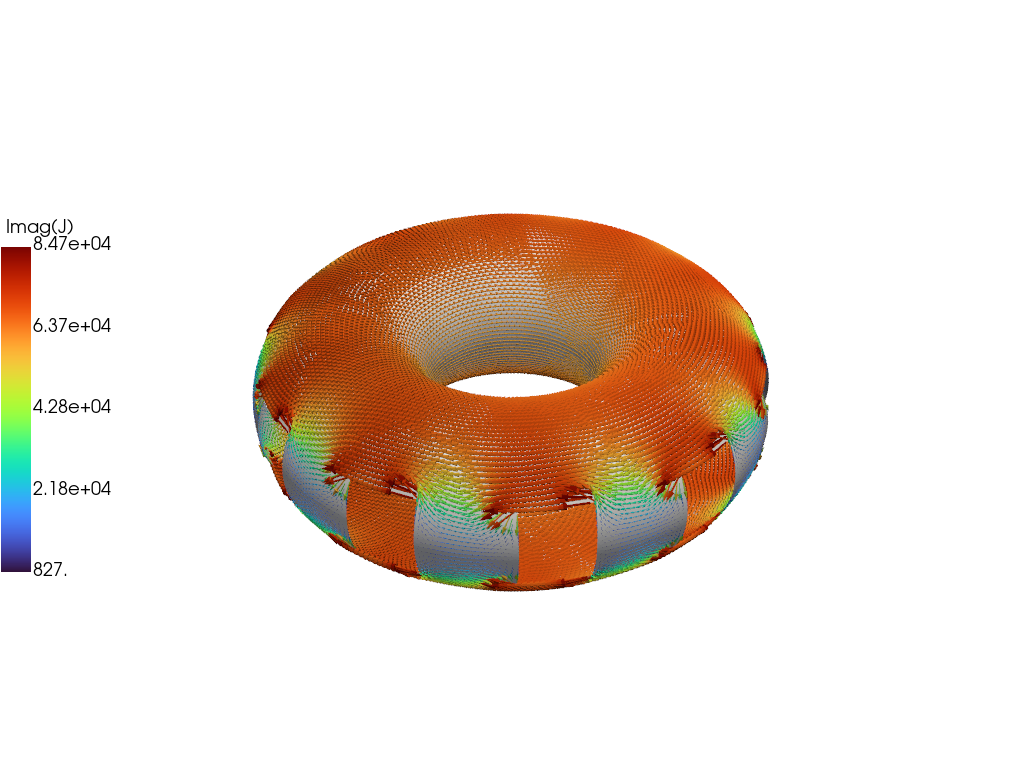

In [9]:
p = pyvista.Plotter()
scale = 0.2/(np.linalg.norm(J_01,axis=1)).max()
arrows = grid.glyph(scale="vectors", orient="vectors", factor=scale)
p.add_mesh(arrows, cmap="turbo", scalar_bar_args={'title': "Imag(J)", "vertical": True, "position_y":0.25, "position_x": 0.0})
p.add_mesh(grid, color="white", opacity=1.0, show_edges=False)
p.show(jupyter_backend='static')